In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("515k-hotel-reviews-data-in-europe.zip")

In [3]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [4]:
df.shape

(515738, 17)

In [5]:
df.Hotel_Address.value_counts()[:10]

163 Marsh Wall Docklands Tower Hamlets London E14 9SJ United Kingdom              4789
372 Strand Westminster Borough London WC2R 0JJ United Kingdom                     4256
Westminster Bridge Road Lambeth London SE1 7UT United Kingdom                     4169
Scarsdale Place Kensington Kensington and Chelsea London W8 5SY United Kingdom    3578
7 Pepys Street City of London London EC3N 4AF United Kingdom                      3212
1 Inverness Terrace Westminster Borough London W2 3JP United Kingdom              2958
Wrights Lane Kensington and Chelsea London W8 5SP United Kingdom                  2768
225 Edgware Road Westminster Borough London W2 1JU United Kingdom                 2628
4 18 Harrington Gardens Kensington and Chelsea London SW7 4LH United Kingdom      2565
1 Waterview Drive Greenwich London SE10 0TW United Kingdom                        2551
Name: Hotel_Address, dtype: int64

In [6]:
df.Hotel_Address[0].split()[-1]

'Netherlands'

In [7]:
def get_country(adress):
    country = adress.split()[-1]
    if country == "Kingdom":
        return("United Kingdom")
    else:
        return(country)
    
df['Country'] = df.Hotel_Address.apply(lambda x: get_country(x))
df.Country.value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: Country, dtype: int64

In [8]:
def get_city(adress, country):
    city = adress.split()[-2]
    if country == "United Kingdom":
        return(adress.split()[-5])
    else:
        return(city)

df['City'] = df[['Hotel_Address','Country']].apply(lambda x: get_city(x[0], x[1]), axis=1)

In [9]:
df.City.value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: City, dtype: int64

In [10]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng', 'Country', 'City'],
      dtype='object')

In [11]:
df[['City','Hotel_Name']].groupby(['City','Hotel_Name']).count().reset_index().groupby(['City']).count()

,Hotel_Name
City,
Amsterdam,105
Barcelona,211
London,400
Milan,162
Paris,458
Vienna,158


In [17]:
df[['Hotel_Name','City','lng','lat']].groupby(['Hotel_Name','City']).median().reset_index().head(10)

,Hotel_Name,City,lng,lat
0,11 Cadogan Gardens,London,-0.159235,51.493616
1,1K Hotel,Paris,2.365874,48.863932
2,25hours Hotel beim MuseumsQuartier,Vienna,16.354630,48.206474
3,41,London,-0.143649,51.498147
4,45 Park Lane Dorchester Collection,London,-0.151536,51.506371
5,88 Studios,London,-0.209073,51.499279
6,9Hotel Republique,Paris,2.360586,48.870842
7,A La Villa Madame,Paris,2.331526,48.848861
8,ABaC Restaurant Hotel Barcelona GL Monumento,Barcelona,2.136294,41.410694
9,AC Hotel Barcelona Forum a Marriott Lifestyle ...,Barcelona,2.218805,41.410131


In [13]:
def get_hotels(city):
    ct = df.Hotel_Name[df.City == city].value_counts().to_frame().reset_index()
    ct.columns = ['Hotel_Name','Count']
    return(ct)
    
df_mapa = get_hotels('Barcelona').merge(df[['Hotel_Name','lng','lat']].groupby(['Hotel_Name']).median().reset_index(),
                                        left_on='Hotel_Name', right_on='Hotel_Name', how='left')
df_mapa.head()

,Hotel_Name,Count,lng,lat
0,Eurostars Grand Marina Hotel GL,1082,2.181698,41.371308
1,Catalonia Atenas,1061,2.186601,41.411006
2,Catalonia Plaza Catalunya,964,2.168292,41.386529
3,Catalonia Barcelona Plaza,932,2.149117,41.375029
4,Barcelona Princess,897,2.218653,41.410972


<function matplotlib.pyplot.show(*args, **kw)>

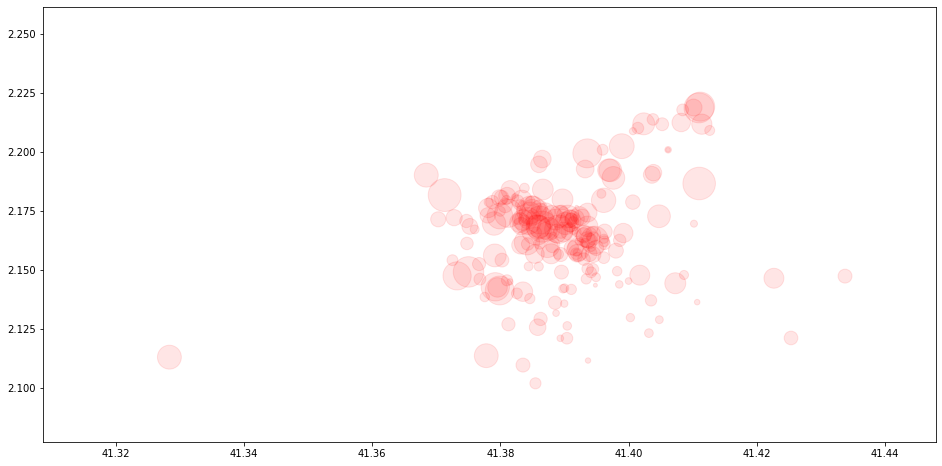

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.scatter(df_mapa.lat, df_mapa.lng, c='red', s=df_mapa.Count, alpha=0.1)
plt.show

### Scrapping Hotel Prices
First i create a standardized name of the hotel which i will use in Google to look for its booking.com adress
It will be done in 2 steps. First i need to scrap the address in booking and i will use Google for this.
Second i will visit each page and pick the price and see if there's more interesting information to scrap.

In [48]:
scrap = df[['Hotel_Name','City']].groupby(['Hotel_Name','City']).count().reset_index()
scrap = scrap.apply(lambda x: ('Hotel ' + x[0] + ' ' + x[1]), axis=1)
scrap

0                       Hotel 11 Cadogan Gardens London
1                                  Hotel 1K Hotel Paris
2       Hotel 25hours Hotel beim MuseumsQuartier Vienna
3                                       Hotel 41 London
4       Hotel 45 Park Lane Dorchester Collection London
                             ...                       
1489              Hotel citizenM London Bankside London
1490            Hotel citizenM London Shoreditch London
1491              Hotel citizenM Tower of London London
1492                Hotel every hotel Piccadilly London
1493                     Hotel pentahotel Vienna Vienna
Length: 1494, dtype: object

This is the adress i will use in Google. The idea is that i will pick the first adress coming from booking.com as the final address of the hotel in the sistem. Once i will gather all of the addresses i will try to scrap the prices in each one of them

In [50]:
google = ['https://www.google.com/search?sxsrf=&q=booking.com'+i.replace(" ", "+") for i in scrap]

Once i've got all the addresses of a Google search i start scrapping the addresses in Booking

#### Scrapping of Booking addresses

In [88]:
import requests
from bs4 import BeautifulSoup

In [91]:
bookingadress = []
for i, hotel in enumerate(google[:5]):
    URL = hotel
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    bkng = []
    for page in soup.find_all('a', href=True):
        if page['href'][:37] == '/url?q=https://www.booking.com/hotel/':
            bkng.append(page['href'][7:].split('&', 1)[0])
    bookingadress.append(bkng[0])
    print(i,bkng[0])

0 https://www.booking.com/hotel/gb/number-eleven.es.html
1 https://www.booking.com/hotel/fr/1-k-hotel.es.html
2 https://www.booking.com/hotel/at/25hours-wien.es.html
3 https://www.booking.com/hotel/gb/41clubredcarnations.es.html
4 https://www.booking.com/hotel/gb/parklane.en-gb.html


In [87]:
bookingadress

['https://www.booking.com/hotel/gb/number-eleven.es.html',
 'https://www.booking.com/hotel/fr/1-k-hotel.es.html',
 'https://www.booking.com/hotel/at/25hours-wien.es.html',
 'https://www.booking.com/hotel/gb/41clubredcarnations.es.html',
 'https://www.booking.com/hotel/gb/parklane.en-gb.html']

#### Scrapping of Booking prices

In [224]:
head = {"User-Agent":"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36"}
URL = bookingadress[4]
page = requests.get(URL, headers=head)
soup = BeautifulSoup(page.content, 'html.parser')
print(bookingadress[4])

https://www.booking.com/hotel/gb/parklane.en-gb.html


In [225]:
a = soup.find_all("script",type="application/ld+json")

In [228]:
type(a)

bs4.element.ResultSet

In [229]:
a

[<script type="application/ld+json">
 {
    "@context" : "http://schema.org",
    "aggregateRating" : {
       "ratingValue" : 9.5,
       "@type" : "AggregateRating",
       "bestRating" : 10,
       "reviewCount" : 73
    },
    "hasMap" : "https://maps.googleapis.com/maps/api/staticmap?sensor=false&markers=color:blue%7c51.5064962,-0.1518117&size=1600x1200&zoom=15&center=51.5064962,-0.1518117&client=gme-booking&channel=booking-frontend&signature=0ixSmPJy5uchMlxhGVu7d1ZSCBk=",
    "@type" : "Hotel",
    "description" : "Overlooking Hyde Park, 45 Park Lane features an on-site fitness studio and a modern American steak restaurant.",
    "image" : "https://r-cf.bstatic.com/images/hotel/max500/830/8304314.jpg",
    "priceRange" : "Prices for upcoming dates start at € 821 per night (We Price Match)",
    "name" : "45 Park Lane - Dorchester Collection",
    "url" : "https://www.booking.com/hotel/gb/parklane.en-gb.html",
    "address" : {
       "streetAddress" : "45 Park Lane, Westminster B